# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [1]:
import time

# Capture the start time
start_time: float = time.time()

In [2]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
from pyscf import gto
from pyscf.geomopt import geometric_solver
from gpu4pyscf.dft import rks
from pyscf.hessian import thermo
from termcolor import colored

/opt/conda/lib/python3.11/site-packages/cupy/_environment.py:370: UserWarning: CuPy failed to preload library (/opt/conda/lib/python3.11/site-packages/cutensor/lib/libcutensor.so.2): OSError (libcublasLt.so.11: cannot open shared object file: No such file or directory)
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/gpu4pyscf/lib/cutensor.py:136: UserWarning: using cupy as the tensor contraction engine.
  warnings.warn(f'using {contract_engine} as the tensor contraction engine.')


In [3]:
!pwd

/app


**Change the below variables accordingly**

In [4]:
inp_smiles: str="C1=CC=C(C=C1)C(=O)O"
dielectric_value: float=46.7
output_dir: str="benzoic_acid"
num_conf: int = 1000     # Number of conformers to be generated
E_avg_proton: float=-274.8838384  # E_H (solv) in kcal/mol
pKa_EXP: float=10.8 # Experimental pKa

In [5]:
import os

os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [6]:
!pwd

/app/benzoic_acid


In [7]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

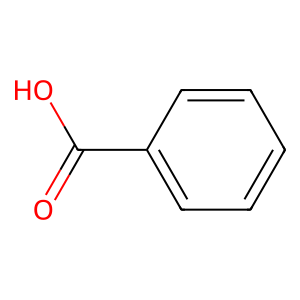

In [8]:
display_2d_structure(inp_smiles)


**Importing the necessary libraries**

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [10]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_xyz,opt_conf_energy_csv,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

File initial_generated_conformers.sdf has been removed.
File optimized_generated_conformers.sdf has been removed.
File opt_conf_energies.csv has been removed.
File optimized_generated_conformers.smi has been removed.
File tanimoto_similarity.csv has been removed.
File feasible_geom_energies.csv has been removed.
File infeasible_geometries.csv has been removed.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
File rmsd_matrix-mx_flags.dat has been removed.
File pairwise_RMSDs.csv has been removed.
File cluster_rep_conformers.csv has been removed.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
Directory cluster_rep_conformers has been removed.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 1 μs, sys: 4.59 ms, total: 4.59 ms
Wall time: 4.27 ms


## **Step 2: Generating Conformers**

Generating conformers for a given molecule using the RDKit-ETKDG method.

In [11]:
%%time

import time
import sys


mol: Chem.Mol= generate_conformers(inp_smiles, num_conf)  # Call the function to generate conformers
save_conformers_to_sdf(mol, init_conf_sdf)       # Save conformers to SDF file



CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 432 ms


In [12]:
# Find the number of atoms in the molecule
num_atoms_generated_conf: int = mol.GetNumAtoms()

## **Step 3: Optimizing Conformers**

In [13]:
%%time

### Optimize the generated conformers and save the optimized coordinates
opt_mol, conformer_energies = mmff_optimize_conformers(mol)     # Call the function to optimize conformers
save_conformers_to_sdf(opt_mol,opt_conf_sdf)
# print(conformer_energies)

num_opt_conf: int= opt_mol.GetNumConformers()


### Save the energies of optimized to a CSV file
conformer_energies_items : List[Tuple[int, float]] = list(conformer_energies.items())
energy_DF: pd.DataFrame = pd.DataFrame(conformer_energies_items, columns=['conformer_id', 'energy_in_kcalpermol'])
energy_DF.to_csv(opt_conf_energy_csv, index=False)

CPU times: user 2.78 s, sys: 0 ns, total: 2.78 s
Wall time: 2.78 s


In [14]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 88.8 ms


1000 molecules converted


In [15]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [16]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
print("Total number of conformers generated:", num_conf)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 1000
Total number of conformers for which the geometry feasibility was checked: 1000
Total number of conformers generated: 1000
CPU times: user 615 μs, sys: 0 ns, total: 615 μs
Wall time: 411 μs


In [17]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 5.13 ms, sys: 13 μs, total: 5.14 ms
Wall time: 4.8 ms


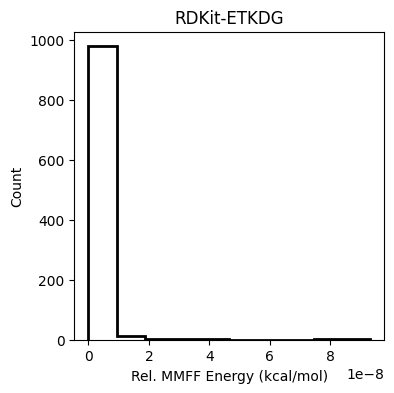

CPU times: user 245 ms, sys: 684 ms, total: 928 ms
Wall time: 88.8 ms


In [18]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('RDKit-ETKDG')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [19]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 3.39 ms, sys: 598 μs, total: 3.99 ms
Wall time: 14 s


In [20]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 85.5 ms, sys: 24.9 ms, total: 110 ms
Wall time: 114 ms


In [21]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 177 ms, sys: 22.5 ms, total: 200 ms
Wall time: 200 ms


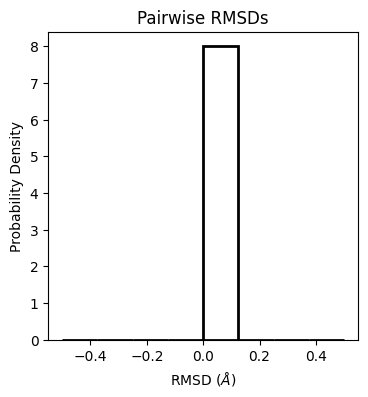

CPU times: user 136 ms, sys: 111 ms, total: 247 ms
Wall time: 131 ms


In [22]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 5: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [23]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 8.94 ms, sys: 1.12 ms, total: 10.1 ms
Wall time: 10.8 ms


In [24]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters: int= 20

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 2.36 ms, sys: 837 μs, total: 3.19 ms
Wall time: 4.02 ms


## **Step 6: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [25]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 2.58 ms, sys: 0 ns, total: 2.58 ms
Wall time: 2.79 ms


In [26]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 114 ms, sys: 1.75 ms, total: 116 ms
Wall time: 115 ms


## **Step 7: Calculating the Minimum RMSD**

Calculating the min rmsd between refrence conformer and cluster representatives.

# calculating the min rmsd between refrence conformer and cluster representatives
result: float = calculate_min_rmsd(f"../{ref_confo_path}",cluster_reps_sdf)
print(f"Min RMSD 20 Clusters: {result}")

# Append the result to the text file
with open('outputs.txt', 'a') as file:
    file.write(f'Min_RMSD_20_cluster : {result}\n')

# Step 8: Geometry optimization of neutral conformers using DFT

In [27]:
def get_atom_list(sdf_file):
    molecules = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = next(molecules)  # Assuming you have one molecule in the SDF

    # Get the first conformer to access 3D coordinates
    conformer = mol.GetConformer()

    # Extract atomic symbols and coordinates
    atom_list = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        atom_list.append((atom.GetSymbol(), (pos.x, pos.y, pos.z)))
    return atom_list


def opti_PCM(mol, eps, xyz_filename, charge_filename, xc):
    start_time = time.time()
    # Set up the DFT calculation
    mf = rks.RKS(mol).density_fit()  # Use density fitting for efficiency
    mf.xc = xc  # Set the exchange-correlation functional

    # SCF convergence Criteria
    mf.conv_tol = 1e-8  # Energy convergence
    mf.conv_tol_grad = 3e-4  # Gradient convergence
    mf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf = mf.PCM()  # Initialize solvation model
    mf.grids.atom_grid = (99, 590)
    mf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    # Perform geometry optimization
    print("Starting geometry optimization...")
    mol_opt = geometric_solver.optimize(mf, max_steps=200, xtol=1e-8, gtol=3e-4, etol=1e-8)

    # Output optimized geometry
    optimized_atoms = [(atom[0], mol_opt.atom_coords(unit='Angstrom')[i]) for i, atom in enumerate(mol_opt.atom)]

    # Ensure SCF calculation is performed after optimization
    mf_scf = rks.RKS(mol_opt).density_fit()
    mf_scf.xc = xc

    # SCF convergence Criteria
    mf_scf.conv_tol = 1e-8  # Energy convergence
    mf_scf.conv_tol_grad = 3e-4  # Gradient convergence
    mf_scf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf_scf = mf_scf.PCM()  # Initialize solvation model
    mf_scf.grids.atom_grid = (99, 590)
    mf_scf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf_scf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf_scf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    #Run the scf
    mf_scf.kernel()

    #Mulliken Charge Analysis
    analysis = mf_scf.analyze()
    mulliken_charges = analysis[0][1]  # Get the Mulliken charges

    # Save captured output to file
    with open(charge_filename, "w") as charge_file:
        charge_file.write("Atom Index  Atom Symbol  Mulliken Charge\n")
        for i, charge in enumerate(mulliken_charges):
            atom_symbol = mol.atom_symbol(i)  # Get the atom symbol
            charge_file.write(f"{i+1}             {atom_symbol}        {charge:.6f}\n")


    # Extract the final energy in Hartree
    final_energy_hartree = mf_scf.e_tot

    # Convert energy from Hartree to kJ/mol
    #hartree_to_kjmol = 2625.5
    hartree_to_kcalmol=627.509
    final_energy_kcalmol = final_energy_hartree * hartree_to_kcalmol

    # Save optimized geometry to XYZ file
    with open(xyz_filename, 'w') as xyz_file:
        xyz_file.write(f"{len(optimized_atoms)}\n")
        xyz_file.write(f"Energy: {final_energy_kcalmol:.6f} kcal/mol\n")
        for symbol, coords in optimized_atoms:
            formatted_coords = ' '.join(f"{coord:.8f}" for coord in coords)
            xyz_file.write(f"{symbol} {formatted_coords}\n")

    print(f"Optimized geometry saved to '{xyz_filename}'.")

    # Print the final energy
    print(f"Final energy: {final_energy_hartree:.8f} Hartree ({final_energy_kcalmol:.6f} kcal/mol)")

    # Record the end time
    opt_time = time.time()

    # Calculate and print the total run time
    total_opt_time = opt_time - start_time
    print(f"\nOPT Time: {total_opt_time:.2f} seconds")

    print("################################################################")
    return mol_opt

In [28]:
!export LD_LIBRARY_PATH=/opt/conda/lib:$LD_LIBRARY_PATH

In [29]:
# Define basis sets and XC functionals to loop over
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

# Get list of charged SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=0,
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.xyz')
            charge_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


System: uname_result(system='Linux', node='5a83a4914b0b', release='6.8.0-59-generic', version='#61-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 11 23:16:11 UTC 2025', machine='x86_64')  Threads 32
Python 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]
numpy 1.26.4  scipy 1.15.2  h5py 3.13.0
Date: Fri May 16 07:49:31 2025
PySCF version 2.8.0
PySCF path  /opt/conda/lib/python3.11/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.4.1
    CUDA Path None
    CUDA Build Version 11080
    CUDA Driver Version 12080
    CUDA Runtime Version 11080
CUDA toolkit
    cuSolver (11, 4, 1)
    cuBLAS 111103
    cuTENSOR None
Device info
    Device name b'NVIDIA GeForce RTX 4090'
    Device global memory 23.53 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.4.0
GPU4PySCF path  /opt/conda/lib/python3.11/site-packages/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 15
[INPUT] num. electrons = 64
[INPUT] charge = 0
[INPUT] spin (= 

geometric-optimize called with the following command line:
/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-124d6011-ffc3-4673-a1b9-ddeb34bddaa7.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.151000   0.362800  -0.085800    0.000000  0.000000  0.000000
   C  -1.242700   1.387900   0.179300    0.000000  0.000000  0.000000
   C   0.126400   1.115300   0.225900    0.000000  0.000000  0.000000
   C   0.589400  -0.188100   0.006300    0.000000  0.000000  0.000000
   C  -0.327200  -1.213500  -0.259500    0.000000  0.000000  0.000000
   C  -1.694900  -0.936900  -0.305200    0.000000  0.000000  0.000000
   C   2.032100  -0.528300   0.045000    0.000000  0.000000  0.000000
   O   2.510200  -1.633100  -0.134900   -0.000000  0.000000  0.000000
   O   2.813800   0.534200   0.308300    0.000000  0.000000  0.000000
   H  -3.216400   0.577300  -0.121600    0.000000  0.000000  0.000000
   H  -1.600500   2.400300   0.350000    0.000000 -0.000000 -0.000000
   H   0.822300   1.924300   0.433600    0.000000  0.000000 -0.000000
   H   0.021400  -2.229900  -0.4

Step    0 : Gradient = 5.594e-03/1.342e-02 (rms/max) Energy = -420.7360187975
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 5.13877e-01 5.60777e-01 9.66438e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.142276   0.356866  -0.086301    0.008724 -0.005934 -0.000501
   C  -1.238289   1.388304   0.179851    0.004411  0.000404  0.000551
   C   0.129454   1.126552   0.228284    0.003054  0.011252  0.002384
   C   0.571925  -0.182014   0.006189   -0.017475  0.006086 -0.000111
   C  -0.326379  -1.221087  -0.261102    0.000821 -0.007587 -0.001602
   C  -1.690747  -0.947077  -0.306951    0.004153 -0.010177 -0.001751
   C   2.019406  -0.514627   0.046979   -0.012694  0.013673  0.001979
   O   2.413602  -1.647142  -0.144142   -0.096598 -0.014042 -0.009242
   O   2.836496   0.523738   0.308159    0.022696 -0.010462 -0.000141
   H  -3.210009   0.571509  -0.122068    0.006391 -0.005791 -0.000468
   H  -1.599560   2.401217   0.350510    0.000940  0.000917  0.000510
   H   0.837306   1.926631   0.435140    0.015006  0.002331  0.001540
   H   0.044211  -2.230761  -0.4

<class 'gpu4pyscf.solvent.pcm.PCM'> does not have attributes  v_grids_n


tot grids = 481024
Default auxbasis aug-cc-pvdz-jkfit is used for O aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for H aug-cc-pVDZ
Default auxbasis aug-cc-pvdz-jkfit is used for C aug-cc-pVDZ
Solvent Energy = -0.0133037511919362
init E= -420.722876391444
Solvent Energy = -0.0138606121097309
cycle= 1 E= -420.735220682244  delta_E= -0.0123  |ddm|= 2.48
Solvent Energy = -0.0133815479790613
cycle= 2 E= -420.734985630975  delta_E= 0.000235  |ddm|= 0.816
Solvent Energy = -0.0135746105326314
cycle= 3 E= -420.736045556387  delta_E= -0.00106  |ddm|= 0.291
Solvent Energy = -0.0135196254164607
cycle= 4 E= -420.736057334605  delta_E= -1.18e-05  |ddm|= 0.0698
Solvent Energy = -0.0135461680219026
cycle= 5 E= -420.736061613483  delta_E= -4.28e-06  |ddm|= 0.0304
Solvent Energy = -0.0135320985389843
cycle= 6 E= -420.736061796527  delta_E= -1.83e-07  |ddm|= 0.00759
Solvent Energy = -0.0135349907249736
cycle= 7 E= -420.736061827937  delta_E= -3.14e-08  |ddm|= 0.00293
Solvent Energy = -0.0135345

Step    1 : Displace = 3.140e-02/9.825e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 4.310e-03/9.535e-03 (rms/max) E (change) = -420.7360618301 (-4.303e-05) Quality = 0.037
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 5.29226e-01 7.63760e-01 9.66145e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.146824   0.361753  -0.085685   -0.004549  0.004887  0.000616
   C  -1.237611   1.388214   0.179888    0.000678 -0.000090  0.000037
   C   0.128538   1.116101   0.226193   -0.000915 -0.010451 -0.002091
   C   0.575485  -0.191139   0.004673    0.003560 -0.009125 -0.001515
   C  -0.332079  -1.221953  -0.261693   -0.005700 -0.000866 -0.000591
   C  -1.695469  -0.942444  -0.306403   -0.004721  0.004633  0.000548
   C   2.024533  -0.526374   0.045064    0.005128 -0.011747 -0.001915
   O   2.459457  -1.644656  -0.140335    0.045856  0.002486  0.003807
   O   2.820950   0.524358   0.307130   -0.015546  0.000619 -0.001029
   H  -3.214129   0.579375  -0.120844   -0.004120  0.007866  0.001225
   H  -1.592876   2.403290   0.351407    0.006683  0.002073  0.000897
   H   0.839172   1.913677   0.432769    0.001865 -0.012954 -0.002371
   H   0.033298  -2.233061  -0.4

Step    2 : Displace = 1.604e-02/4.607e-02 (rms/max) Trust = 1.570e-02 (-) Grad = 1.616e-03/3.348e-03 (rms/max) E (change) = -420.7367681424 (-7.063e-04) Quality = 0.914
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 5.46121e-01 8.51542e-01 9.69043e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.151023   0.362718  -0.085809   -0.004199  0.000965 -0.000124
   C  -1.239319   1.386638   0.179562   -0.001708 -0.001576 -0.000326
   C   0.127161   1.113579   0.225821   -0.001377 -0.002523 -0.000372
   C   0.581930  -0.191404   0.005208    0.006445 -0.000265  0.000535
   C  -0.333464  -1.215507  -0.260534   -0.001384  0.006446  0.001159
   C  -1.697976  -0.940537  -0.306281   -0.002507  0.001908  0.000122
   C   2.030627  -0.530683   0.044834    0.006094 -0.004309 -0.000230
   O   2.475953  -1.644920  -0.139074    0.016495 -0.000265  0.001261
   O   2.815620   0.524924   0.307094   -0.005330  0.000566 -0.000036
   H  -3.217917   0.580445  -0.120950   -0.003788  0.001070 -0.000107
   H  -1.594091   2.401663   0.351113   -0.001214 -0.001627 -0.000294
   H   0.837518   1.910952   0.432443   -0.001653 -0.002725 -0.000327
   H   0.033098  -2.226255  -0.4

Step    3 : Displace = 6.386e-03/1.641e-02 (rms/max) Trust = 2.220e-02 (+) Grad = 7.955e-04/1.871e-03 (rms/max) E (change) = -420.7368428356 (-7.469e-05) Quality = 0.750
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 5.44623e-01 7.44459e-01 9.70220e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.147518   0.364468  -0.085221    0.003505  0.001750  0.000588
   C  -1.238395   1.390551   0.180516    0.000924  0.003913  0.000954
   C   0.126740   1.112639   0.225791   -0.000422 -0.000939 -0.000030
   C   0.576917  -0.194170   0.004414   -0.005014 -0.002766 -0.000794
   C  -0.332607  -1.223465  -0.262041    0.000857 -0.007958 -0.001507
   C  -1.694848  -0.939170  -0.305861    0.003128  0.001367  0.000420
   C   2.026535  -0.532398   0.044376   -0.004092 -0.001715 -0.000459
   O   2.481092  -1.642842  -0.138158    0.005139  0.002079  0.000916
   O   2.805622   0.526540   0.306935   -0.009998  0.001616 -0.000159
   H  -3.214573   0.581460  -0.120552    0.003344  0.001015  0.000399
   H  -1.592589   2.405841   0.352203    0.001502  0.004177  0.001090
   H   0.840851   1.906878   0.432174    0.003333 -0.004074 -0.000269
   H   0.035091  -2.234049  -0.4

Step    4 : Displace = 6.299e-03/1.154e-02 (rms/max) Trust = 3.140e-02 (+) Grad = 7.729e-04/1.756e-03 (rms/max) E (change) = -420.7368361033 (+6.732e-06) Quality = -0.225
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 6.31025e-01 7.96480e-01 9.68158e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.149185   0.363411  -0.085547   -0.001667 -0.001057 -0.000326
   C  -1.239009   1.388744   0.180132   -0.000614 -0.001807 -0.000384
   C   0.126750   1.113810   0.226036    0.000010  0.001171  0.000245
   C   0.578100  -0.192403   0.004854    0.001184  0.001767  0.000440
   C  -0.333381  -1.220173  -0.261458   -0.000774  0.003293  0.000583
   C  -1.696554  -0.940113  -0.306174   -0.001706 -0.000944 -0.000313
   C   2.027918  -0.531066   0.044751    0.001383  0.001332  0.000375
   O   2.477685  -1.643386  -0.138501   -0.003408 -0.000544 -0.000343
   O   2.811023   0.525632   0.307182    0.005401 -0.000908  0.000247
   H  -3.216232   0.580735  -0.120817   -0.001658 -0.000725 -0.000265
   H  -1.593829   2.403817   0.351738   -0.001240 -0.002023 -0.000466
   H   0.839554   1.909183   0.432553   -0.001297  0.002305  0.000379
   H   0.034852  -2.230451  -0.4

Step    5 : Displace = 3.086e-03/5.812e-03 (rms/max) Trust = 3.149e-03 (-) Grad = 2.222e-04/4.962e-04 (rms/max) E (change) = -420.7368579736 (-2.187e-05) Quality = 0.967
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 6.42534e-01 7.76475e-01 9.69053e-01



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.149842   0.363188  -0.085636   -0.000657 -0.000224 -0.000089
   C  -1.239814   1.388564   0.180157   -0.000806 -0.000180  0.000025
   C   0.126052   1.114036   0.226189   -0.000698  0.000225  0.000153
   C   0.578612  -0.191723   0.005123    0.000512  0.000680  0.000269
   C  -0.333467  -1.218876  -0.261226   -0.000087  0.001296  0.000233
   C  -1.696960  -0.940272  -0.306296   -0.000406 -0.000158 -0.000121
   C   2.028449  -0.529961   0.045156    0.000531  0.001105  0.000406
   O   2.476603  -1.642943  -0.138374   -0.001081  0.000443  0.000128
   O   2.812410   0.526175   0.307665    0.001388  0.000543  0.000483
   H  -3.216905   0.580372  -0.120976   -0.000673 -0.000363 -0.000160
   H  -1.594930   2.403552   0.351781   -0.001101 -0.000265  0.000043
   H   0.838227   1.909930   0.432853   -0.001327  0.000747  0.000300
   H   0.034860  -2.229082  -0.4

Step    6 : Displace = 9.424e-04/1.809e-03 (rms/max) Trust = 4.454e-03 (+) Grad = 8.215e-05/1.826e-04 (rms/max) E (change) = -420.7368591931 (-1.219e-06) Quality = 0.838
Hessian Eigenvalues: 2.29998e-02 2.30000e-02 2.30000e-02 ... 6.46871e-01 8.06408e-01 9.69593e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.150472   0.362919  -0.085733   -0.000630 -0.000269 -0.000097
   C  -1.239930   1.387838   0.180146   -0.000116 -0.000726 -0.000011
   C   0.126260   1.115010   0.226595    0.000208  0.000974  0.000405
   C   0.578275  -0.190897   0.005388   -0.000338  0.000826  0.000265
   C  -0.333642  -1.218177  -0.261112   -0.000175  0.000699  0.000114
   C  -1.697287  -0.940436  -0.306424   -0.000327 -0.000164 -0.000129
   C   2.028067  -0.529252   0.045463   -0.000382  0.000710  0.000307
   O   2.476734  -1.642039  -0.138053    0.000131  0.000904  0.000320
   O   2.811861   0.526907   0.308082   -0.000550  0.000732  0.000417
   H  -3.217531   0.580188  -0.121109   -0.000626 -0.000184 -0.000132
   H  -1.595436   2.402671   0.351769   -0.000506 -0.000881 -0.000012
   H   0.838078   1.911220   0.433402   -0.000148  0.001290  0.000549
   H   0.035052  -2.228250  -0.4

Step    7 : Displace = 5.641e-04/9.688e-04 (rms/max) Trust = 6.299e-03 (+) Grad = 1.294e-04/3.464e-04 (rms/max) E (change) = -420.7368589429 (+2.502e-07) Quality = -0.567
Hessian Eigenvalues: 2.29998e-02 2.30000e-02 2.30000e-02 ... 6.46871e-01 8.06408e-01 9.69593e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 50.736 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1049 MB)
XC library gpu4pyscf.dft.libxc version 7.0.0 (CUDA)
    unable to decode the reference due to https://github.com/NVIDIA/cuda-python/issues/29
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x766dfb709580>
grids dens level: 3
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x766dfb709620>
User specified grid scheme (99, 590)
small_rho_cutoff = 1e-07
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev

# Step 9: Geometry optimization of charged conformers using DFT

In [30]:
def get_charge(file_path):
    """
    Reads the number of atoms directly from an SDF file.

    Args:
        file_path: The path to the SDF file.

    Returns:
        An integer representing the number of atoms, or None if the
        information cannot be extracted or the file cannot be read.
    """
    def get_num_atoms(file_path):
        try:
            with open(file_path, 'r') as f:
                # Skip the first three lines of the SDF file
                for _ in range(3):
                    f.readline()
                # Read the fourth line which contains the number of atoms
                fourth_line = f.readline().strip()
                parts = fourth_line.split()
                if parts:
                    try:
                        num_atoms = int(parts[0])
                        return num_atoms
                    except ValueError:
                        print("Error: Could not convert atom count to integer.")
                        return None
                else:
                    print("Error: Fourth line of SDF is empty.")
                    return None
        except FileNotFoundError:
            print(f"Error: File not found at {file_path}")
            return None
        except Exception as e:
            print(f"An error occurred while reading the file: {e}")
            return None
        
    #Get the charge
    A_atoms = get_num_atoms(file_path)
    HA_atoms= get_num_atoms(file_path.replace("_charged", ""))
    charge=A_atoms-HA_atoms
    print(f"Charge of {file_path}: {charge}")
    return charge

In [31]:
#!cp /app/rep_of_cluster_*_charged.sdf /app/output_dir/cluster_rep_conformers/. 

In [40]:
# Get list of charged SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*charged.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)
    charge = get_charge(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=charge,
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.xyz')
            charge_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


Charge of cluster_rep_conformers/rep_of_cluster_1_charged.sdf: -1
System: uname_result(system='Linux', node='5a83a4914b0b', release='6.8.0-59-generic', version='#61-Ubuntu SMP PREEMPT_DYNAMIC Fri Apr 11 23:16:11 UTC 2025', machine='x86_64')  Threads 32
Python 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]
numpy 1.26.4  scipy 1.15.2  h5py 3.13.0
Date: Fri May 16 07:52:11 2025
PySCF version 2.8.0
PySCF path  /opt/conda/lib/python3.11/site-packages/pyscf/__init__.py
CUDA Environment
    CuPy 13.4.1
    CUDA Path None
    CUDA Build Version 11080
    CUDA Driver Version 12080
    CUDA Runtime Version 11080
CUDA toolkit
    cuSolver (11, 4, 1)
    cuBLAS 111103
    cuTENSOR None
Device info
    Device name b'NVIDIA GeForce RTX 4090'
    Device global memory 23.53 GB
    CuPy memory fraction 0.9
    Num. Devices 1
GPU4PySCF 1.4.0
GPU4PySCF path  /opt/conda/lib/python3.11/site-packages/gpu4pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 

geometric-optimize called with the following command line:
/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-124d6011-ffc3-4673-a1b9-ddeb34bddaa7.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********      .


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.168100  -0.238200  -0.091400    0.000000  0.000000  0.000000
   C  -1.576700   0.941000   0.362200    0.000000  0.000000  0.000000
   C  -0.185200   1.054500   0.405800    0.000000  0.000000  0.000000
   C   0.618500  -0.016000  -0.006200    0.000000  0.000000  0.000000
   C   0.019200  -1.197600  -0.460800   -0.000000  0.000000  0.000000
   C  -1.372100  -1.307000  -0.502800    0.000000  0.000000  0.000000
   C   2.099300   0.055200   0.021000    0.000000  0.000000  0.000000
   O   2.862900  -0.829500  -0.319400    0.000000  0.000000  0.000000
   O   2.558700   1.235100   0.475000    0.000000  0.000000 -0.000000
   H  -3.251600  -0.324300  -0.124500    0.000000  0.000000  0.000000
   H  -2.199200   1.772900   0.682400    0.000000  0.000000  0.000000
   H   0.261400   1.979600   0.761700    0.000000 -0.000000 -0.000000
   H   0.633900  -2.035700  -0.7

Step    0 : Gradient = 3.682e-02/1.165e-01 (rms/max) Energy = -420.2619387589
Hessian Eigenvalues: 2.30000e-02 2.30000e-02 2.30000e-02 ... 4.64397e-01 5.60744e-01 9.66207e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.177802  -0.257198  -0.098900   -0.009702 -0.018998 -0.007500
   C  -1.591495   0.926734   0.356459   -0.014795 -0.014266 -0.005741
   C  -0.203338   1.067325   0.410418   -0.018138  0.012825  0.004618
   C   0.638497   0.024944   0.009509    0.019997  0.040944  0.015709
   C   0.033602  -1.154778  -0.444356    0.014402  0.042822  0.016444
   C  -1.353338  -1.308152  -0.503358    0.018762 -0.001152 -0.000558
   C   2.144121   0.127676   0.049301    0.044821  0.072476  0.028301
   O   2.613292  -0.940560  -0.361318   -0.249608 -0.111060 -0.041918
   O   2.735667   1.206678   0.464422    0.176967 -0.028422 -0.010578
   H  -3.262159  -0.358670  -0.137858   -0.010559 -0.034370 -0.013358
   H  -2.225849   1.753245   0.674542   -0.026649 -0.019655 -0.007858
   H   0.231788   1.996571   0.767842   -0.029612  0.016971  0.006142
   H   0.672067  -1.978048  -0.7

Step    1 : Displace = 9.806e-02/2.765e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 2.126e-02/4.719e-02 (rms/max) E (change) = -420.2635342108 (-1.595e-03) Quality = 0.122
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 4.64279e-01 9.10077e-01 9.94982e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.186202  -0.247549  -0.095207   -0.008400  0.009649  0.003693
   C  -1.593596   0.933047   0.358869   -0.002101  0.006313  0.002410
   C  -0.203437   1.052255   0.404595   -0.000099 -0.015069 -0.005823
   C   0.632830   0.004891   0.001789   -0.005667 -0.020053 -0.007720
   C   0.020596  -1.172360  -0.451123   -0.013006 -0.017582 -0.006767
   C  -1.368481  -1.304385  -0.501920   -0.015143  0.003767  0.001439
   C   2.151531   0.117637   0.045466    0.007411 -0.010039 -0.003835
   O   2.767077  -0.895238  -0.343664    0.153785  0.045323  0.017653
   O   2.655305   1.209993   0.465606   -0.080361  0.003315  0.001183
   H  -3.271598  -0.342518  -0.131661   -0.009439  0.016152  0.006197
   H  -2.218707   1.766406   0.679584    0.007142  0.013161  0.005042
   H   0.245396   1.976727   0.760189    0.013609 -0.019844 -0.007653
   H   0.650195  -2.000777  -0.7

Step    2 : Displace = 5.176e-02/1.612e-01 (rms/max) Trust = 4.903e-02 (-) Grad = 8.351e-03/1.808e-02 (rms/max) E (change) = -420.2723930315 (-8.859e-03) Quality = 0.905
Hessian Eigenvalues: 2.29999e-02 2.30000e-02 2.30000e-02 ... 4.64329e-01 9.14435e-01 1.12445e+00



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.155290  -0.240776  -0.093126    0.030912  0.006773  0.002081
   C  -1.582468   0.948429   0.365008    0.011127  0.015382  0.006139
   C  -0.193814   1.073116   0.413532    0.009623  0.020861  0.008937
   C   0.592373  -0.007105  -0.001984   -0.040457 -0.011996 -0.003773
   C   0.027894  -1.202572  -0.462388    0.007298 -0.030212 -0.011265
   C  -1.361470  -1.314505  -0.506074    0.007012 -0.010120 -0.004154
   C   2.115514   0.115346   0.045296   -0.036017 -0.002291 -0.000170
   O   2.776377  -0.881875  -0.338005    0.009301  0.013363  0.005660
   O   2.578791   1.202192   0.458271   -0.076515 -0.007800 -0.007334
   H  -3.240560  -0.332652  -0.128993    0.031038  0.009865  0.002668
   H  -2.215123   1.776841   0.683660    0.003583  0.010435  0.004075
   H   0.280404   1.988631   0.766437    0.035008  0.011904  0.006248
   H   0.673072  -2.021859  -0.7

Step    3 : Displace = 3.419e-02/7.792e-02 (rms/max) Trust = 6.934e-02 (+) Grad = 6.174e-03/1.330e-02 (rms/max) E (change) = -420.2722869565 (+1.061e-04) Quality = -0.076
Hessian Eigenvalues: 2.29958e-02 2.30000e-02 2.30000e-02 ... 6.47171e-01 8.74945e-01 9.84465e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.174927  -0.242321  -0.093736   -0.019637 -0.001545 -0.000610
   C  -1.588321   0.940461   0.361901   -0.005853 -0.007968 -0.003107
   C  -0.197553   1.058127   0.407663   -0.003739 -0.014990 -0.005869
   C   0.611512  -0.006562  -0.001861    0.019139  0.000543  0.000123
   C   0.020357  -1.189852  -0.457585   -0.007537  0.012720  0.004803
   C  -1.369862  -1.307965  -0.503607   -0.008393  0.006540  0.002467
   C   2.137370   0.117908   0.046206    0.021856  0.002562  0.000911
   O   2.802262  -0.878899  -0.336426    0.025885  0.002976  0.001579
   O   2.602506   1.206411   0.460158    0.023716  0.004219  0.001887
   H  -3.260433  -0.333829  -0.129405   -0.019874 -0.001177 -0.000412
   H  -2.215070   1.772714   0.682056    0.000053 -0.004126 -0.001604
   H   0.271215   1.975309   0.761166   -0.009189 -0.013322 -0.005271
   H   0.659723  -2.012264  -0.7

Step    4 : Displace = 1.745e-02/2.609e-02 (rms/max) Trust = 1.709e-02 (-) Grad = 2.243e-03/5.002e-03 (rms/max) E (change) = -420.2732742146 (-9.873e-04) Quality = 0.944
Hessian Eigenvalues: 2.29958e-02 2.30000e-02 2.30000e-02 ... 6.64684e-01 8.70875e-01 9.84619e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.177397  -0.241904  -0.093244   -0.002471  0.000417  0.000492
   C  -1.590003   0.940768   0.362005   -0.001682  0.000307  0.000104
   C  -0.199258   1.052525   0.404646   -0.001705 -0.005601 -0.003017
   C   0.616960  -0.007923  -0.003423    0.005447 -0.001361 -0.001561
   C   0.017011  -1.187835  -0.457558   -0.003346  0.002016  0.000027
   C  -1.372755  -1.307616  -0.503681   -0.002893  0.000349 -0.000074
   C   2.141934   0.118978   0.045012    0.004564  0.001070 -0.001195
   O   2.806845  -0.879240  -0.332662    0.004583 -0.000341  0.003764
   O   2.609533   1.211478   0.463921    0.007027  0.005067  0.003763
   H  -3.262763  -0.333183  -0.128181   -0.002330  0.000646  0.001224
   H  -2.215053   1.773986   0.682875    0.000017  0.001271  0.000819
   H   0.269012   1.969764   0.757588   -0.002203 -0.005545 -0.003578
   H   0.653558  -2.012022  -0.7

Step    5 : Displace = 5.055e-03/9.886e-03 (rms/max) Trust = 2.417e-02 (+) Grad = 1.119e-03/2.511e-03 (rms/max) E (change) = -420.2733289128 (-5.470e-05) Quality = 0.689
Hessian Eigenvalues: 2.29706e-02 2.29995e-02 2.30000e-02 ... 6.39906e-01 8.70361e-01 1.00194e+00



Geometry optimization cycle 7
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.184042  -0.242312  -0.094114   -0.006644 -0.000408 -0.000870
   C  -1.587570   0.936365   0.360161    0.002433 -0.004402 -0.001844
   C  -0.197353   1.052995   0.405605    0.001904  0.000470  0.000959
   C   0.618135  -0.008248  -0.002072    0.001175 -0.000325  0.001351
   C   0.015960  -1.186804  -0.456422   -0.001051  0.001031  0.001136
   C  -1.373996  -1.304531  -0.502793   -0.001241  0.003085  0.000888
   C   2.143140   0.117805   0.047900    0.001205 -0.001173  0.002888
   O   2.808690  -0.878865  -0.333722    0.001845  0.000374 -0.001060
   O   2.610629   1.211289   0.460487    0.001096 -0.000189 -0.003434
   H  -3.269645  -0.332382  -0.129350   -0.006882  0.000801 -0.001169
   H  -2.211681   1.770165   0.680927    0.003372 -0.003820 -0.001948
   H   0.270633   1.970340   0.758920    0.001621  0.000576  0.001333
   H   0.651756  -2.011773  -0.7

Step    6 : Displace = 3.924e-03/6.683e-03 (rms/max) Trust = 2.417e-02 (=) Grad = 9.881e-04/2.123e-03 (rms/max) E (change) = -420.2733222542 (+6.659e-06) Quality = -0.261
Hessian Eigenvalues: 2.29355e-02 2.30000e-02 2.30000e-02 ... 6.29240e-01 8.68313e-01 9.86974e-01



Geometry optimization cycle 8
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.180953  -0.241705  -0.093858    0.003088  0.000607  0.000255
   C  -1.588625   0.938828   0.361088   -0.001056  0.002463  0.000927
   C  -0.198182   1.052885   0.405481   -0.000829 -0.000110 -0.000124
   C   0.617201  -0.008500  -0.002290   -0.000934 -0.000252 -0.000219
   C   0.016246  -1.187507  -0.456759    0.000286 -0.000703 -0.000337
   C  -1.373623  -1.305837  -0.503300    0.000373 -0.001305 -0.000507
   C   2.142203   0.117772   0.047655   -0.000937 -0.000033 -0.000245
   O   2.807716  -0.879188  -0.333494   -0.000974 -0.000322  0.000228
   O   2.609184   1.210255   0.460356   -0.001445 -0.001034 -0.000131
   H  -3.266433  -0.332138  -0.129182    0.003212  0.000244  0.000169
   H  -2.213315   1.772387   0.681780   -0.001634  0.002221  0.000853
   H   0.270775   1.969775   0.758589    0.000142 -0.000565 -0.000331
   H   0.652627  -2.012060  -0.7

Step    7 : Displace = 1.873e-03/3.252e-03 (rms/max) Trust = 1.962e-03 (-) Grad = 3.210e-04/7.346e-04 (rms/max) E (change) = -420.2733413161 (-1.906e-05) Quality = 0.930
Hessian Eigenvalues: 2.29349e-02 2.29999e-02 2.30000e-02 ... 6.39145e-01 8.69956e-01 9.93828e-01



Geometry optimization cycle 9
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.180146  -0.241309  -0.093342    0.000807  0.000396  0.000516
   C  -1.588707   0.939746   0.361339   -0.000082  0.000917  0.000251
   C  -0.198173   1.053490   0.404821    0.000009  0.000605 -0.000660
   C   0.616385  -0.008280  -0.003702   -0.000815  0.000221 -0.001412
   C   0.016048  -1.187781  -0.457684   -0.000198 -0.000274 -0.000925
   C  -1.373950  -1.305983  -0.503378   -0.000327 -0.000146 -0.000077
   C   2.141371   0.117997   0.044536   -0.000832  0.000225 -0.003119
   O   2.806419  -0.881723  -0.330150   -0.001297 -0.002536  0.003345
   O   2.608828   1.208478   0.462558   -0.000356 -0.001777  0.002202
   H  -3.265654  -0.331808  -0.128002    0.000778  0.000330  0.001179
   H  -2.213515   1.773112   0.682259   -0.000200  0.000725  0.000479
   H   0.271341   1.970295   0.757477    0.000566  0.000520 -0.001112
   H   0.652419  -2.012225  -0.7

Step    8 : Displace = 1.796e-03/3.709e-03 (rms/max) Trust = 2.775e-03 (+) Grad = 4.135e-04/1.306e-03 (rms/max) E (change) = -420.2733396877 (+1.628e-06) Quality = -0.368
Hessian Eigenvalues: 2.27794e-02 2.29992e-02 2.30000e-02 ... 6.23528e-01 8.70283e-01 9.92639e-01



Geometry optimization cycle 10
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.180113  -0.240925  -0.093632    0.000034  0.000383 -0.000290
   C  -1.588861   0.940112   0.361367   -0.000154  0.000366  0.000028
   C  -0.198284   1.053010   0.405134   -0.000111 -0.000480  0.000313
   C   0.616469  -0.008766  -0.002983    0.000084 -0.000487  0.000719
   C   0.015685  -1.187931  -0.457223   -0.000362 -0.000151  0.000461
   C  -1.374316  -1.305956  -0.503479   -0.000366  0.000026 -0.000102
   C   2.141479   0.117118   0.046113    0.000107 -0.000880  0.001577
   O   2.806404  -0.881653  -0.331391   -0.000015  0.000070 -0.001241
   O   2.609129   1.208865   0.460867    0.000301  0.000387 -0.001692
   H  -3.265633  -0.331143  -0.128696    0.000021  0.000665 -0.000693
   H  -2.213550   1.773638   0.682106   -0.000034  0.000526 -0.000152
   H   0.271455   1.969617   0.757974    0.000114 -0.000678  0.000497
   H   0.651927  -2.012549  -0.

Step    9 : Displace = 9.089e-04/1.864e-03 (rms/max) Trust = 8.980e-04 (-) Grad = 1.008e-04/2.815e-04 (rms/max) E (change) = -420.2733436060 (-3.918e-06) Quality = 0.965
Hessian Eigenvalues: 2.27263e-02 2.29989e-02 2.30000e-02 ... 6.21659e-01 8.70666e-01 9.92770e-01



Geometry optimization cycle 11
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   C  -2.180659  -0.240367  -0.093747   -0.000546  0.000559 -0.000115
   C  -1.588734   0.940363   0.361238    0.000127  0.000252 -0.000129
   C  -0.198136   1.052894   0.405058    0.000149 -0.000117 -0.000076
   C   0.616341  -0.009128  -0.002934   -0.000128 -0.000361  0.000049
   C   0.015094  -1.187996  -0.457214   -0.000591 -0.000065  0.000008
   C  -1.374950  -1.305503  -0.503520   -0.000634  0.000453 -0.000041
   C   2.141411   0.116146   0.046623   -0.000068 -0.000971  0.000510
   O   2.806044  -0.882861  -0.330887   -0.000360 -0.001208  0.000503
   O   2.609316   1.208028   0.460017    0.000187 -0.000837 -0.000849
   H  -3.266210  -0.330217  -0.128831   -0.000577  0.000926 -0.000136
   H  -2.213116   1.774118   0.681997    0.000434  0.000480 -0.000109
   H   0.271951   1.969319   0.757917    0.000496 -0.000298 -0.000057
   H   0.651086  -2.012845  -0.

Step   10 : Displace = 3.258e-04/8.566e-04 (rms/max) Trust = 1.270e-03 (+) Grad = 4.830e-05/1.214e-04 (rms/max) E (change) = -420.2733439113 (-3.053e-07) Quality = 1.051
Hessian Eigenvalues: 2.27263e-02 2.29989e-02 2.30000e-02 ... 6.21659e-01 8.70666e-01 9.92770e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 66.512 seconds




******** <class 'gpu4pyscf.solvent._attach_solvent.PCMDFRKS'> ********
method = PCMDFRKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'gpu4pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-08
SCF conv_tol_grad = 0.0003
SCF max_cycles = 70
direct_scf = False
max_memory 4000 MB (current use 1076 MB)
XC library gpu4pyscf.dft.libxc version 7.0.0 (CUDA)
    unable to decode the reference due to https://github.com/NVIDIA/cuda-python/issues/29
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x766dfb709580>
grids dens level: 3
symmetrized grids: False
atomic radii adjust function: <function treutler_atomic_radii_adjust at 0x766dfb709620>
User specified grid scheme (99, 590)
small_rho_cutoff = 1e-07
******** <class 'gpu4pyscf.solvent.pcm.PCM'> ********
lebedev

# Step 10: Writing the CSV for pKa Calculations

In [41]:
import os
import csv
import re

def process_xyz_files(folder_path, output_csv_path, pka_value):
    """
    Processes XYZ files in a folder, extracts the numeric value from the second line,
    and writes the data to a CSV file. Adds basis and XC tags extracted from filename.
    Also appends a fixed pKa value to each row.
    """

    # Lists to store data
    neutral_data = []
    charged_data = []

    # Regex patterns
    base_name_pattern = re.compile(r"(rep_of_cluster_\d+)")
    number_pattern = re.compile(r"[-+]?\d*\.\d+|\d+")
    basis_xc_pattern = re.compile(r".*rep_of_cluster_\d+(?:_charged)?_([^_]+)_([^_]+)\.xyz$")

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            filepath = os.path.join(folder_path, filename)
            try:
                with open(filepath, "r") as f:
                    lines = f.readlines()
                    if len(lines) > 1:
                        value_line = lines[1].strip()
                        match = number_pattern.search(value_line)
                        value = match.group(0) if match else "NaN"

                        base_match = base_name_pattern.search(filename)
                        tag_match = basis_xc_pattern.search(filename)

                        if base_match and tag_match:
                            base_name = base_match.group(1)
                            basis_tag = tag_match.group(1)
                            xc_tag = tag_match.group(2)

                            record = [filename, value, basis_tag, xc_tag]

                            if "_charged" in filename:
                                charged_data.append(record)
                            else:
                                neutral_data.append(record)
                        else:
                            print(f"Warning: Could not parse tags in {filename}")
                    else:
                        print(f"Warning: {filename} has less than 2 lines.")
            except Exception as e:
                print(f"Error reading {filename}: {e}")

    # Write CSV
    try:
        full_output_path = os.path.join(folder_path, output_csv_path)
        with open(full_output_path, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "Neutral System", "E_neutral (kcal/mol)", "Basis (Neutral)", "XC (Neutral)",
                "Charged System", "E_charged (kcal/mol)", "Basis (Charged)", "XC (Charged)",
                "pka_exp"
            ])

            max_len = max(len(neutral_data), len(charged_data))
            for i in range(max_len):
                neutral = neutral_data[i] if i < len(neutral_data) else ["", "", "", ""]
                charged = charged_data[i] if i < len(charged_data) else ["", "", "", ""]
                row = neutral + charged + [pka_value]
                writer.writerow(row)

        print(f"Data written to {full_output_path}")
    except Exception as e:
        print(f"Error writing CSV: {e}")

# Usage
if __name__ == "__main__":
    output_csv_path = "DFT_energy.csv"
    fixed_pka_value = pKa_EXP  # You can change this to any constant value
    process_xyz_files(cluster_reps_dir, output_csv_path, fixed_pka_value)


Data written to cluster_rep_conformers/DFT_energy.csv


# Step 11: Data analysis and pKa Calculation

In [48]:
df_pka=pd.read_csv("cluster_rep_conformers/DFT_energy.csv")
df_pka_modified=df_pka[['Basis (Neutral)', 'XC (Neutral)', 'Neutral System', 'E_neutral (kcal/mol)', 'E_charged (kcal/mol)', 'pka_exp' ]]
df_pka_modified['E_proton']=df_pka_modified['pka_exp']*1.36574 +(df_pka_modified['E_neutral (kcal/mol)'] -df_pka_modified['E_charged (kcal/mol)'])


/tmp/ipykernel_15958/1069661826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pka_modified['E_proton']=df_pka_modified['pka_exp']*1.36574 +(df_pka_modified['E_neutral (kcal/mol)'] -df_pka_modified['E_charged (kcal/mol)'])


In [49]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = df_pka_modified['E_neutral (kcal/mol)'] - df_pka_modified['E_neutral (kcal/mol)'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
df_pka_modified['Weights (Neutral Systems)'] = weights / np.sum(weights)

df_pka_modified

/tmp/ipykernel_15958/3424155848.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pka_modified['Weights (Neutral Systems)'] = weights / np.sum(weights)


,Basis (Neutral),XC (Neutral),Neutral System,E_neutral (kcal/mol),E_charged (kcal/mol),pka_exp,E_proton,Weights (Neutral Systems)
0,aug-cc-pVDZ,M06-2X,rep_of_cluster_1_aug-cc-pVDZ_M06-2X.xyz,-264016.165619,-263725.305765,10.8,-276.109862,1.0


In [50]:
#pKa Calculation weighted avg

df_pka_modified['pka_conformer_wise'] = 0.7322 * (
    E_avg_proton -
    (df_pka_modified['E_neutral (kcal/mol)'] - df_pka_modified['E_charged (kcal/mol)'])
)

pka_cal=sum(df_pka_modified['pka_conformer_wise']*df_pka_modified['Weights (Neutral Systems)'])

df_pka_modified.to_csv("cluster_rep_conformers/conformerwise_pka.csv",index=False)

print("pKa_calculated (weighted average) : ", pka_cal)

pKa_calculated (weighted average) :  11.697638622305544


In [45]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [51]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
    "pKa_cal (weighted avg)": [round(pka_cal, 1)]
}

df_final = pd.DataFrame(data)

df_final


,Molecule,Solvent (ε),# Conformers,pKa (Exp),pKa_cal (weighted avg)
0,C1=CC=C(C=C1)C(=O)O,46.7,1,10.8,11.7
